In [1]:
import splitfolders 

In [2]:
input_folder = 'D:/Tasks/Animal_Classification/sample'

In [3]:
splitfolders.ratio(input_folder, output='D:/Tasks/Animal_Classification/dataset', 
                   seed=42, ratio=(.8, .2), 
                   group_prefix=None) 


Copying files: 3600 files [01:11, 50.46 files/s] 


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt

In [4]:
size = 128

train_path = "D:/Tasks/Animal_Classification/dataset/train"
val_path = "D:/Tasks/Animal_Classification/dataset/val"

## Augmenting and Pre-processing dataset 

In [5]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

train_set = train_generator.flow_from_directory(train_path,
                                                target_size = (size, size),
                                                shuffle=True,
                                                batch_size = 32 )


test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

test_set = test_generator.flow_from_directory(val_path,
                                              target_size = (size, size),
                                              shuffle=False,
                                              batch_size = 32)

Found 2880 images belonging to 3 classes.
Found 720 images belonging to 3 classes.


In [6]:
class_num = 3

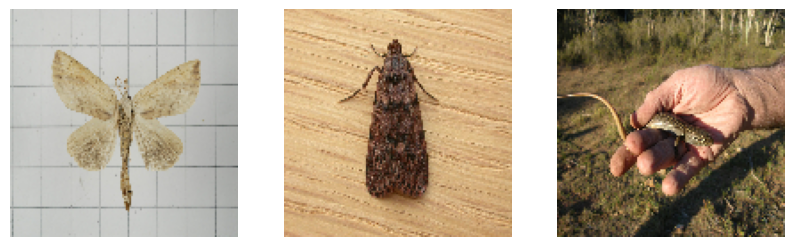

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
for i in range(3):
    batch=next(train_set)   
    img=batch[0][0]  
    image = img.astype('uint8')
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis('off')

## Importing and Modifying the ResNet50 model 

In [8]:
efficientnet = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights='imagenet',
    input_shape=(size,size,3),
    pooling="avg",
    classes=class_num
)

27033600/27018416 [==============================] - 32s 1us/step


In [9]:
efficientnet.summary() 

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 128, 128, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 129, 129, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [10]:
for layer in efficientnet.layers[:-4]:
    layer.trainable = False

## Building the Classification Model 

In [11]:
efficientnet_model = Sequential()

efficientnet_model.add(efficientnet)
efficientnet_model.add(Flatten())

efficientnet_model.add(Dense(256, activation='relu'))
efficientnet_model.add(Dropout(0.5))

efficientnet_model.add(Dense(128, activation='relu'))
efficientnet_model.add(Dropout(0.5))

efficientnet_model.add(Dense(class_num, activation='softmax',name='output'))

In [12]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 3

In [13]:
efficientnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [14]:
history = efficientnet_model.fit(
    train_set,
    validation_data=test_set,
    epochs=20
)

Epoch 1/20
90/90 [==============================] - 137s 1s/step - loss: 0.4537 - accuracy: 0.8219 - val_loss: 0.2274 - val_accuracy: 0.9167
Epoch 2/20
90/90 [==============================] - 73s 809ms/step - loss: 0.2473 - accuracy: 0.9056 - val_loss: 0.2366 - val_accuracy: 0.9194
Epoch 3/20
90/90 [==============================] - 73s 815ms/step - loss: 0.1997 - accuracy: 0.9288 - val_loss: 0.2310 - val_accuracy: 0.9236
Epoch 4/20
90/90 [==============================] - 73s 813ms/step - loss: 0.1369 - accuracy: 0.9483 - val_loss: 0.2865 - val_accuracy: 0.9167
Epoch 5/20
90/90 [==============================] - 73s 807ms/step - loss: 0.1460 - accuracy: 0.9500 - val_loss: 0.2427 - val_accuracy: 0.9222
Epoch 6/20
90/90 [==============================] - 73s 812ms/step - loss: 0.0895 - accuracy: 0.9667 - val_loss: 0.2784 - val_accuracy: 0.9181
Epoch 7/20
90/90 [==============================] - 74s 817ms/step - loss: 0.0834 - accuracy: 0.9715 - val_loss: 0.3219 - val_accuracy: 0.9125
E

In [15]:
efficientnet_model.save("Animal_Classifier_EfficientNetB1.h5")

C:\Users\Athindu\anaconda3\envs\flaskProject\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## 

## Model Evaluation -> Accuracy, F1 Score, Precision, Recall, Confusion Matrix, etc 

In [16]:
train_loss, train_acc = efficientnet_model.evaluate(train_set)

90/90 [==============================] - 57s 634ms/step - loss: 0.0018 - accuracy: 0.9993


In [17]:
test_loss, test_acc = efficientnet_model.evaluate(test_set)

23/23 [==============================] - 15s 630ms/step - loss: 0.3676 - accuracy: 0.9264


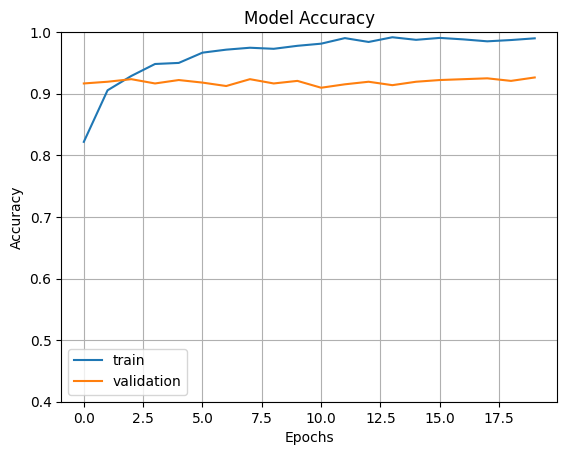

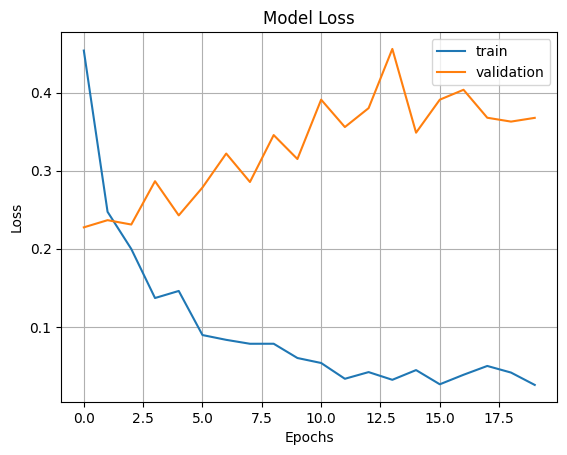

In [19]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [20]:
prediction = efficientnet_model.predict(test_set) 
efficientnet_classes=np.argmax(prediction,axis=1)

In [21]:
test_labels = test_set.classes

In [22]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, efficientnet_classes))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       240
           1       0.93      0.88      0.91       240
           2       0.94      0.96      0.95       240

    accuracy                           0.93       720
   macro avg       0.93      0.93      0.93       720
weighted avg       0.93      0.93      0.93       720



### 

In [44]:
correct_predictions = np.nonzero(efficientnet_classes == test_labels)[0]
incorrect_predictions = np.nonzero(efficientnet_classes != test_labels)[0]

print( "Correct classifications: ", len(correct_predictions))
print( "Misclassifications: ", len(incorrect_predictions))

Correct classifications:  667
Misclassifications:  53


## Classifications

In [25]:
import glob

class_names = []

for directory in glob.glob("D:/Tasks/Animal_Classification/dataset/train/*"):
    label = os.path.basename(os.path.normpath(directory))
    class_names.append(label)

print(class_names)

['Frog', 'Lizard', 'Moths']


In [28]:
ef_model = tf.keras.models.load_model('D:/Tasks/Animal_Classification/API - Animal_Classifier/Animal_Classifier_EfficientNetB1.h5')

[[3.2680258e-13 1.0000000e+00 2.3698876e-15]]
[1]
1
Classification:  Lizard


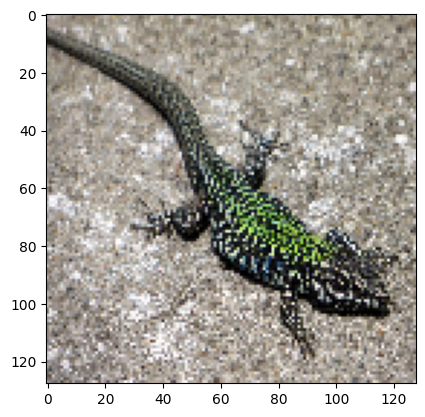

In [29]:
image_path = "D:/Tasks/Animal_Classification/dataset/089deaa014d1adc3.jpg"

test_img = tf.keras.utils.load_img(image_path, target_size = (size, size)) 
test_image = tf.keras.utils.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
test_image = tf.keras.applications.efficientnet.preprocess_input(test_image)
    
result = ef_model.predict(test_image)

print(result)
print(np.argmax(result,axis=1))
print(int(np.argmax(result,axis=1)))

plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])